# Library

In [1]:
# ===============================
# Librairies
# ===============================
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import math  

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
from IPython.display import Image, display

# import yfinance as yf
import ta
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
import shap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

import optuna
from functools import partial

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/Users/tomcuel/.venvs/global_env/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Data import and feature creations

In [2]:
"""
# ===============================
# Download daily OHLCV data
# ===============================
#symbol = "^GSPC"
symbol = "ES=F"
start  = "2010-01-01"
end    = None

df = yf.download(symbol, start=start, end=end)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)
df.head()
"""

'\n# ===============================\n# Download daily OHLCV data\n# ===============================\n#symbol = "^GSPC"\nsymbol = "ES=F"\nstart  = "2010-01-01"\nend    = None\n\ndf = yf.download(symbol, start=start, end=end)\nif isinstance(df.columns, pd.MultiIndex):\n    df.columns = df.columns.get_level_values(0)\ndf.head()\n'

In [3]:
# ===============================
# Load a real time series
# ===============================
def load_data_from_csv(filepath):
    # Load CSV without header
    df = pd.read_csv(filepath, header=None)
    # Combine first two rows into a single header
    header1 = df.iloc[0].fillna("")  # market symbols
    header2 = df.iloc[1].fillna("")  # OHLCV etc
    # Create new column names
    new_header = []
    for h1, h2 in zip(header1, header2):
        if h1 != "":
            new_header.append(f"{h1}_{h2}" if h2 != "" else h1)
        else:
            new_header.append(h2)
    # Drop first two rows from the data
    df = df[2:]
    df.columns = new_header
    df = df.reset_index(drop=True)
    # Optional: remove fully empty columns
    df = df.dropna(axis=1, how='all')
    return df

df_load = load_data_from_csv('../data/Stock_Market_Initial_Data.csv')

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/847830797.py:6: DtypeWarning: Columns (1,2,3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,29,30,31,32,33,34,36,37,38,39,40,41,43,44,45,46,47,48,50,51,52,53,54,55,57,58,59,60,61,62,64,65,66,67,68,69,71,72,73,74,75,76,78,79,80,81,82,83,85,86,87,88,89,90,92,93,94,95,96,97,99,100,101,102,103,104,106,107,108,109,110,111,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139,141,142,143,144,145,146,148,149,150,151,152,153,155,156,157,158,159,160,162,163,164,165,166,167,169,170,171,172,173,174,176,177,178,179,180,181,183,184,185,186,187,188,190,191,192,193,194,195,197,198,199,200,201,202,204,205,206,207,208,209,211,212,213,214,215,216,218,219,220,221,222,223,225,226,227,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, header=None)


In [4]:
# ===============================
# Function to extract market data for a specific index from the CSV file
# ===============================
def extract_market_data(df, market_name):
    """
    Extract Date + OHLCV columns for a given market
    """
    df.columns = df.columns.str.strip()
    high_col_candidates = [c for c in df.columns if c.startswith(f"{market_name}_High")]
    if not high_col_candidates:
        raise ValueError(f"Column starting with {market_name}_High not found.")
    
    high_col = high_col_candidates[0]
    high_idx = df.columns.get_loc(high_col)
    
    # Date + next 6 columns (High, Low, Open, Close, Volume, Adj Close)
    cols_idx = [0] + list(range(high_idx, high_idx + 6))
    df_market = df.iloc[:, cols_idx].copy()
    df_market = df_market.reset_index(drop=True)
    
    # Rename columns for clarity
    df_market.columns = ['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
    df_market[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']] = df_market[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']].astype(float)
    return df_market

# Example for ^GSPC
df_gspc = extract_market_data(df_load, '^GSPC')
df_gspc['Date'] = pd.to_datetime(df_gspc['Date'])
df_gspc = df_gspc.set_index('Date')
df_gspc = df_gspc.drop(columns=['Adj Close'])

In [5]:
# ===============================
# Preprocess the data to add additional informations
# ===============================
def add_indicators(df: pd.DataFrame, horizon=5) -> pd.DataFrame:
    df = df.copy()


    # ── Log return target ─────────────────────────────────────
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Target'] = df['Log_Return'].shift(-horizon).rolling(horizon).sum()


    # ── Momentum ──────────────────────────────────────────────
    for length in [5, 10, 15]:
        df[f"RSI_{length}"] = ta.momentum.RSIIndicator(close=df["Close"], window=length).rsi()
    df["ROC_10"] = ta.momentum.ROCIndicator(close=df["Close"], window=10).roc()
    df["MOM_4"] = df["Close"] - df["Close"].shift(4)
    df["MOM_10"] = df["Close"] - df["Close"].shift(10)


    # ── Oscillators ───────────────────────────────────────────
    stoch = ta.momentum.StochasticOscillator(high=df["High"], low=df["Low"], close=df["Close"], window=14, smooth_window=3)
    df["Stoch_K"] = stoch.stoch()
    df["Stoch_D"] = stoch.stoch_signal()
    df["CCI_20"] = ta.trend.CCIIndicator(high=df["High"], low=df["Low"], close=df["Close"], window=20).cci()


    # ── Trend ─────────────────────────────────────────────────
    for length in [5, 10, 20, 50]:
        df[f"SMA_{length}"] = ta.trend.SMAIndicator(close=df["Close"], window=length).sma_indicator()
        df[f"EMA_{length}"] = ta.trend.EMAIndicator(close=df["Close"], window=length).ema_indicator()

    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()

    df['VWMA_20'] = ta.volume.VolumeWeightedAveragePrice(df['High'], df['Low'], df['Close'], df['Volume'], 20).volume_weighted_average_price()


    # ── Volatility ───────────────────────────────────────────
    bb = ta.volatility.BollingerBands(df['Close'], 20)
    df['BB_Mavg'] = bb.bollinger_mavg()
    df['BB_HBand'] = bb.bollinger_hband()
    df['BB_LBand'] = bb.bollinger_lband()
    df['BB_Width'] = df['BB_HBand'] - df['BB_LBand']

    df['ATR_14'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], 14).average_true_range()
    
    kc = ta.volatility.KeltnerChannel(df['High'], df['Low'], df['Close'], 20)
    df['KC_HBand'] = kc.keltner_channel_hband()
    df['KC_LBand'] = kc.keltner_channel_lband()
    df['KC_Width'] = df['KC_HBand'] - df['KC_LBand']


    # ── Volume ───────────────────────────────────────────────
    df['Volume_Change'] = df['Volume'].pct_change()
    df['OBV'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['AD'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Close'], df['Volume']).acc_dist_index()
    df['VWAP'] = (df['Close']*df['Volume']).cumsum() / df['Volume'].cumsum()
    df['Volume_SMA_20'] = df['Volume'].rolling(20).mean()


    # ── OHLC ratios ──────────────────────────────────────────
    df['Candle_Body'] = df['Close'] - df['Open']
    df['Upper_Shadow'] = df['High'] - df[['Close','Open']].max(axis=1)
    df['Lower_Shadow'] = df[['Close','Open']].min(axis=1) - df['Low']
    df['HL_Ratio'] = df['High'] / df['Low']
    df['CO_Ratio'] = df['Close'] / df['Open']


    # ── Returns ──────────────────────────────────────────────
    df = df.replace([np.inf, -np.inf], np.nan)  # only a volume change issue on the last one for horizon 
    df = df.dropna()
    return df


# Example usage
# only taking the last 5 years ??
lenght = int(df_gspc.shape[0] * 0.3)
df_downsample = df_gspc.iloc[lenght:].copy()
HORIZON = 1
df_ta = add_indicators(df_downsample, horizon=HORIZON)
df_ta.tail()

,High,Low,Open,Close,Volume,Log_Return,Target,RSI_5,RSI_10,RSI_15,ROC_10,MOM_4,MOM_10,Stoch_K,Stoch_D,CCI_20,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,MACD,MACD_Signal,VWMA_20,BB_Mavg,BB_HBand,BB_LBand,BB_Width,ATR_14,KC_HBand,KC_LBand,KC_Width,Volume_Change,OBV,AD,VWAP,Volume_SMA_20,Candle_Body,Upper_Shadow,Lower_Shadow,HL_Ratio,CO_Ratio
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-10-31,3893.729980,3863.179932,3881.850098,3871.979980,4.820620e+09,-0.007482,-0.004110,65.774677,60.754441,56.387173,5.275494,12.869873,194.030029,91.919593,90.294109,124.256277,3854.010059,3845.483250,3790.106030,3802.238815,3728.432007,3771.600270,3834.880815,3822.396517,15.466627,-18.616501,3729.655361,3728.432007,3924.705465,3532.158548,392.546917,81.252578,3804.315308,3649.392334,154.922974,0.081000,1.243213e+12,1.826164e+12,2048.290311,4.550854e+09,-9.870118,11.879882,8.800048,1.007908,0.997457
2022-11-01,3911.790039,3843.800049,3901.790039,3856.100098,4.481210e+09,-0.004110,-0.025320,60.901044,58.745439,55.177018,3.659163,25.500000,136.120118,86.747115,92.537731,107.842743,3853.408057,3849.022199,3803.718042,3812.031776,3731.690515,3779.647872,3829.243013,3823.718226,19.550767,-10.983047,3734.359042,3731.690515,3934.074875,3529.306155,404.768720,80.305250,3809.481482,3654.305505,155.175977,-0.070408,1.238732e+12,1.823304e+12,2048.765268,4.517586e+09,-45.689941,10.000000,12.300049,1.017688,0.988290
2022-11-02,3894.439941,3758.679932,3852.899902,3759.689941,4.899000e+09,-0.025320,-0.010642,38.981284,48.031250,48.417689,1.746339,-47.610108,64.530029,54.201906,77.622872,53.840091,3839.226025,3819.244780,3810.171045,3802.515079,3730.511011,3777.747117,3821.862212,3821.207313,14.836953,-5.819047,3736.397379,3730.511011,3931.951727,3529.070294,402.881433,84.266305,3813.722982,3653.396004,160.326977,0.093232,1.233833e+12,1.818478e+12,2049.256537,4.547876e+09,-93.209961,41.540039,1.010009,1.036119,0.975808
2022-11-03,3750.590088,3698.149902,3733.250000,3719.889893,4.625290e+09,-0.010642,0.013527,32.875348,44.323286,45.929077,1.476080,-181.170166,54.109864,29.742971,56.897331,-6.792108,3821.743994,3786.126484,3815.582031,3787.492318,3729.279504,3772.236905,3813.444609,3817.234081,7.799778,-3.095282,3734.587856,3729.279504,3930.663732,3527.895277,402.768454,82.643000,3811.525492,3651.825492,159.700000,-0.055871,1.229208e+12,1.817688e+12,2049.709313,4.566536e+09,-13.360107,17.340088,21.739991,1.014180,0.996421
2022-11-04,3796.340088,3708.840088,3766.979980,3770.550049,0.000000e+00,0.013527,0.009568,46.266901,49.803817,49.471006,0.474320,-101.429931,17.800049,46.574904,43.506594,17.181309,3795.641992,3780.934339,3817.362036,3784.411905,3735.824011,3772.076252,3804.873208,3815.403334,6.238702,-1.228485,3738.627630,3735.824011,3933.608242,3538.039780,395.568462,82.989928,3816.743331,3656.894332,159.848999,-1.000000,1.229208e+12,1.817688e+12,2049.709313,4.344053e+09,3.570069,25.790039,58.139892,1.023592,1.000948


In [6]:
df_ta.describe(include='all')

,High,Low,Open,Close,Volume,Log_Return,Target,RSI_5,RSI_10,RSI_15,ROC_10,MOM_4,MOM_10,Stoch_K,Stoch_D,CCI_20,SMA_5,EMA_5,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,MACD,MACD_Signal,VWMA_20,BB_Mavg,BB_HBand,BB_LBand,BB_Width,ATR_14,KC_HBand,KC_LBand,KC_Width,Volume_Change,OBV,AD,VWAP,Volume_SMA_20,Candle_Body,Upper_Shadow,Lower_Shadow,HL_Ratio,CO_Ratio
count,4506.000000,4506.000000,4506.000000,4506.000000,4.506000e+03,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000,4.506000e+03,4.506000e+03,4506.000000,4.506000e+03,4506.000000,4506.000000,4506.000000,4506.000000,4506.000000
mean,2069.945268,2045.517965,2058.206275,2058.482831,3.771260e+09,0.000254,0.000256,55.620140,54.914895,54.494773,0.316025,2.296383,5.836858,62.882357,62.893060,27.837054,2057.342248,2057.333069,2055.874103,2055.889164,2053.009463,2053.018697,2044.404685,2044.059091,4.042013,4.052833,2051.180132,2053.009463,2117.566510,1988.452416,129.114093,26.301733,2076.787994,2028.217161,48.570833,0.017441,6.601298e+11,8.590051e+11,1402.252483,3.765512e+09,0.276556,4.735882,5.961754,1.012599,1.000225
std,990.298149,979.115847,985.013938,984.964712,1.230677e+09,0.012433,0.012434,19.286295,13.383612,10.803832,3.315253,49.809416,76.293839,31.186387,28.747621,108.387777,984.218949,984.086889,983.288817,983.081201,981.575428,981.166242,976.659670,975.144132,26.068534,24.345456,980.449449,981.575428,1017.545707,948.139694,121.552479,20.416390,992.796161,970.221264,36.857137,0.204897,3.983977e+11,5.928496e+11,242.762800,1.045550e+09,21.795598,6.770738,8.745699,0.010565,0.011002
min,695.270019,666.789978,679.280029,676.530029,0.000000e+00,-0.127652,-0.127652,3.049884,11.391117,17.534880,-25.884597,-496.100097,-732.020019,0.000000,0.866648,-401.396755,690.332007,691.785279,707.927002,713.782198,736.972003,743.372703,788.956798,792.835619,-237.020227,-198.640715,736.010237,736.972003,806.269033,648.975559,19.553685,8.240423,763.642666,710.537505,14.112012,-1.000000,6.591880e+09,-5.051849e+08,1152.775368,1.335125e+09,-150.220214,0.000000,0.000000,1.001457,0.912769
25%,1291.685028,1277.047516,1285.217468,1285.359955,3.070600e+09,-0.004112,-0.004112,41.361881,45.449292,46.599150,-1.038864,-15.017517,-18.252502,36.750831,37.734555,-53.593758,1284.543982,1284.988554,1284.121759,1283.134556,1283.286508,1282.017039,1281.300997,1283.652185,-4.201529,-3.689823,1283.280756,1283.286508,1315.028439,1253.070833,59.661634,13.848915,1298.455638,1269.601255,25.715512,-0.078713,2.352193e+11,2.067974e+11,1203.884087,3.226045e+09,-7.079926,0.689941,0.780029,1.006294,0.996163
50%,1788.460022,1772.270019,1779.719971,1781.184998,3.606075e+09,0.000697,0.000697,57.481046,56.476475,55.691584,0.682135,5.419983,11.805023,71.232669,71.162226,57.141402,1778.594983,1783.888505,1778.347003,1780.718569,1776.332254,1775.421875,1735.794608,1743.186136,7.188647,6.707912,1774.732049,1776.332254,1807.219610,1737.653974,88.515815,18.563901,1788.705254,1762.468249,34.875055,-0.001218,7.318876e+11,8.793638e+11,1318.953416,3.644638e+09,1.059815,2.679993,3.459961,1.009696,1.000576
75%,2696.084900,2664.349976,2684.097473,2682.507568,4.283140e+09,0.005665,0.005670,71.009874,65.080227,62.743668,2.075662,23.017517,37.249970,91.260890,89.126737,110.978971,2682.203015,2682.008731,2685.543738,2687.941134,2683.614990,2686.594510,2684.904799,2692.367196,15.961619,15.483485,2681.351083,2683.614990,2788.699956,2587.803367,148.154903,30.285127,2718.747150,2646.561810,56.587301,0.088970,9.725792e+11,1.395556e+12,1541.872966,4.164305e+09,9.097473,5.989990,7.460052,1.015140,1.005054
max,4818.620117,4780.040039,4804.509766,4796.560059,1.145623e+10,0.109572,0.109572,96.540206,89.023607,86.191530,21.638353,325.150146,426.2

In [7]:
df_ta.isna().sum()

High             0
Low              0
Open             0
Close            0
Volume           0
Log_Return       0
Target           0
RSI_5            0
RSI_10           0
RSI_15           0
ROC_10           0
MOM_4            0
MOM_10           0
Stoch_K          0
Stoch_D          0
CCI_20           0
SMA_5            0
EMA_5            0
SMA_10           0
EMA_10           0
SMA_20           0
EMA_20           0
SMA_50           0
EMA_50           0
MACD             0
MACD_Signal      0
VWMA_20          0
BB_Mavg          0
BB_HBand         0
BB_LBand         0
BB_Width         0
ATR_14           0
KC_HBand         0
KC_LBand         0
KC_Width         0
Volume_Change    0
OBV              0
AD               0
VWAP             0
Volume_SMA_20    0
Candle_Body      0
Upper_Shadow     0
Lower_Shadow     0
HL_Ratio         0
CO_Ratio         0
dtype: int64

In [8]:
# ===============================
# Check stationnarity for the time serie
# ===============================
def check_stationarity(series):  # ADF test
    result = adfuller(series.dropna())  # Drop NaN values if any
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print(" --> The series is stationary")
    else:
        print(" --> The series is not stationary")

print("Testing the stationnarity of the time serie")
check_stationarity(df_ta['Close'])
print()
print("Testing the stationnarity of the log return of the time serie")
check_stationarity(df_ta['Log_Return'])

Testing the stationnarity of the time serie
ADF Statistic: 0.01565372729477964
p-value: 0.9598076513132762
 --> The series is not stationary

Testing the stationnarity of the log return of the time serie
ADF Statistic: -16.24029470392642
p-value: 3.733473315065624e-29
 --> The series is stationary


# Vizualizations

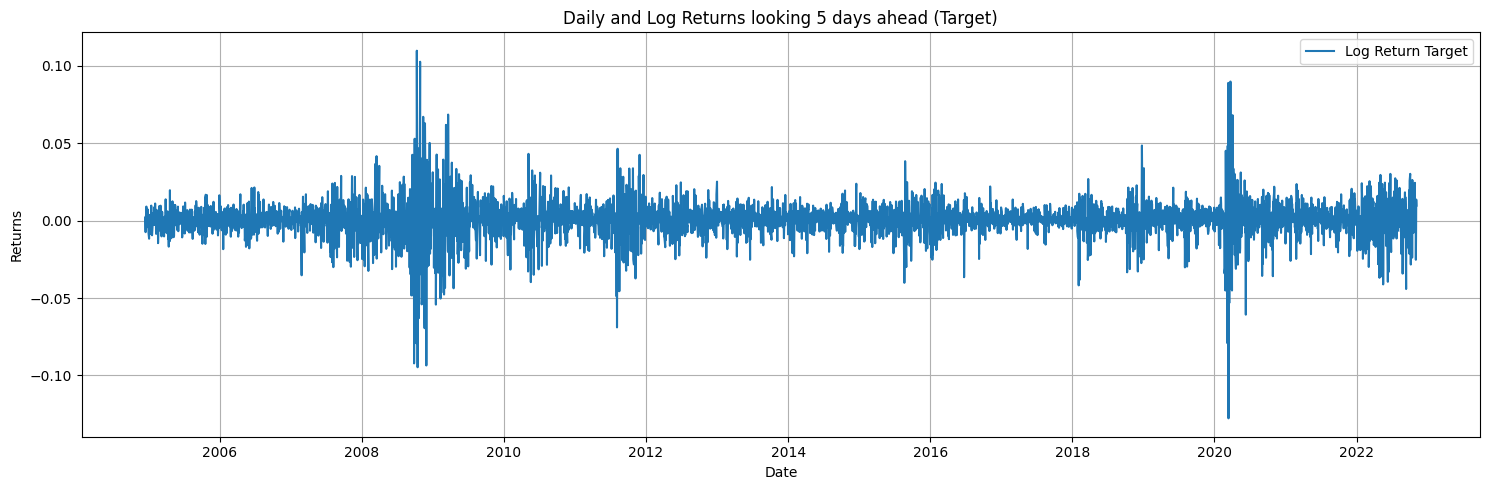

In [9]:
plt.figure(figsize=(15,5))
plt.plot(df_ta['Target'], label='Log Return Target')
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title(f"Daily and Log Returns looking 5 days ahead (Target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

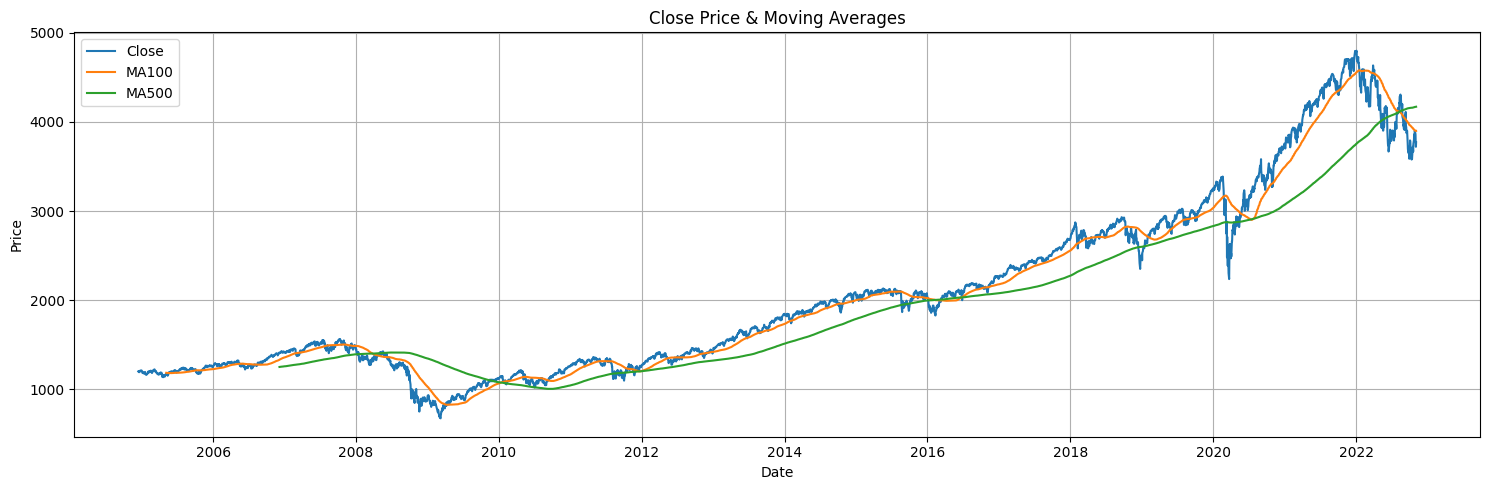

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df_ta['Close'], label='Close')
plt.plot(df_ta['Close'].rolling(window=100).mean(), label='MA100')
plt.plot(df_ta['Close'].rolling(window=500).mean(), label='MA500')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price & Moving Averages")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

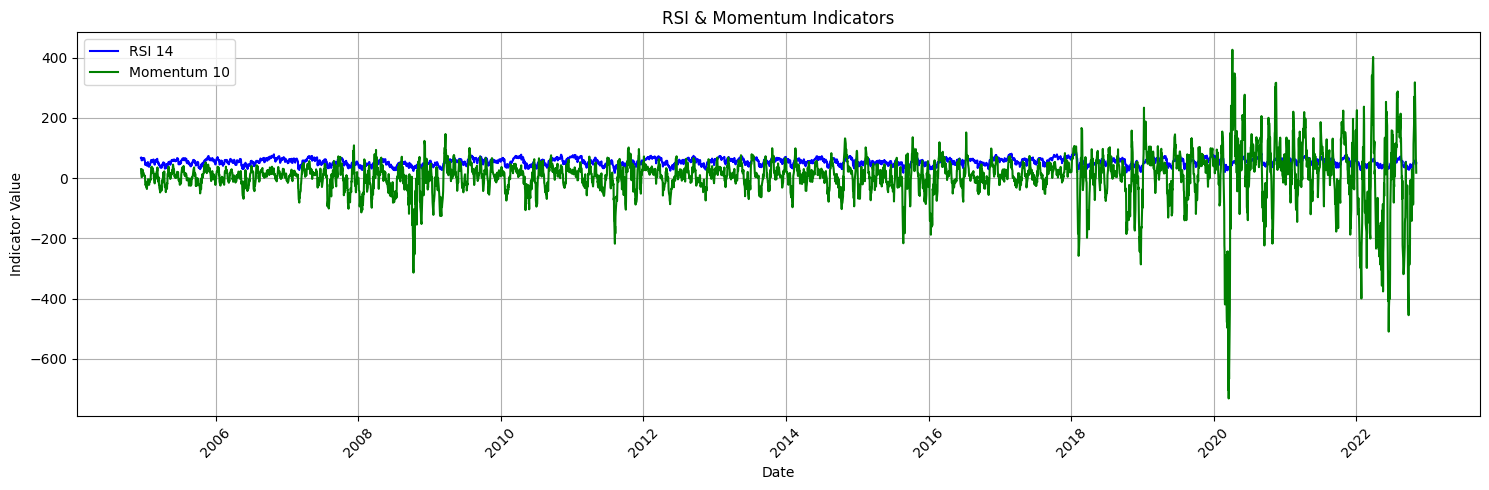

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(df_ta['RSI_15'], label='RSI 14', color='blue')
plt.plot(df_ta['MOM_10'], label='Momentum 10', color='green')
plt.xlabel("Date")
plt.ylabel("Indicator Value")
plt.title("RSI & Momentum Indicators")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


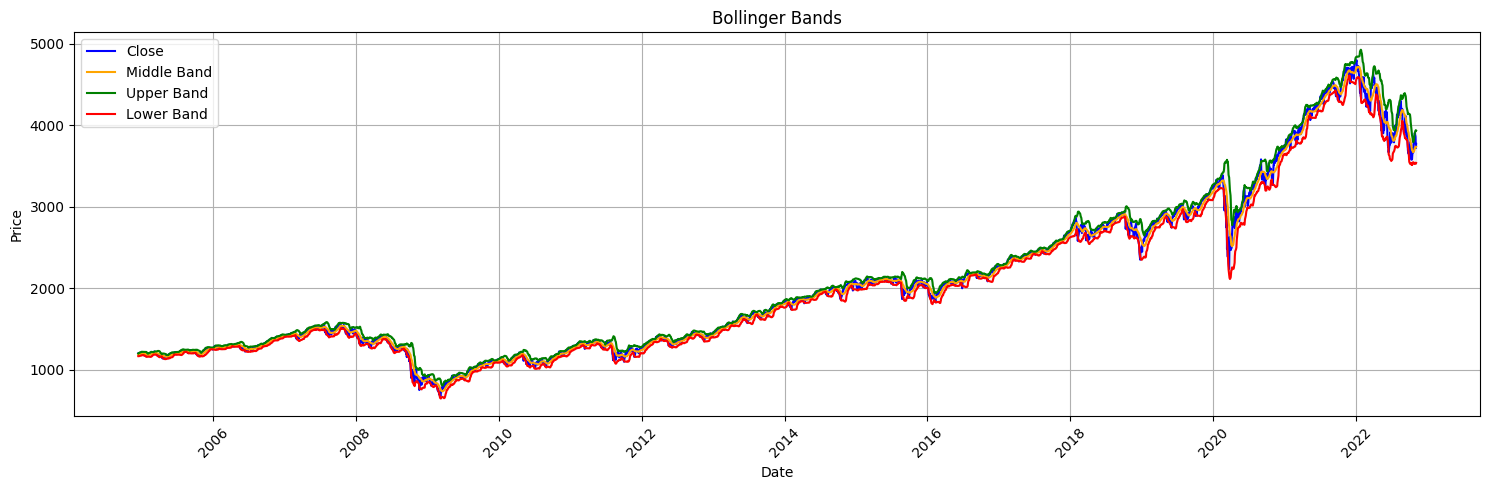

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(df_ta['Close'], label='Close', color='blue')
plt.plot(df_ta['BB_Mavg'], label='Middle Band', color='orange')
plt.plot(df_ta['BB_HBand'], label='Upper Band', color='green')
plt.plot(df_ta['BB_LBand'], label='Lower Band', color='red')
plt.fill_between(df_ta.index, df_ta['BB_LBand'], df_ta['BB_HBand'], color='gray', alpha=0.1)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Bollinger Bands")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

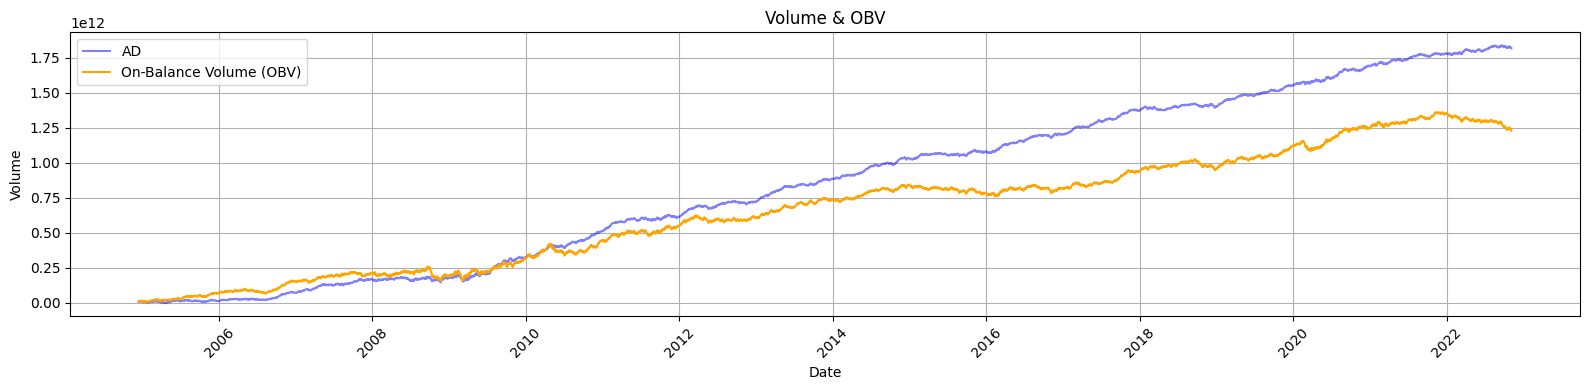

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(df_ta['AD'], label='AD', color='blue', alpha=0.5)
plt.plot(df_ta['OBV'], label='On-Balance Volume (OBV)', color='orange')
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Volume & OBV")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

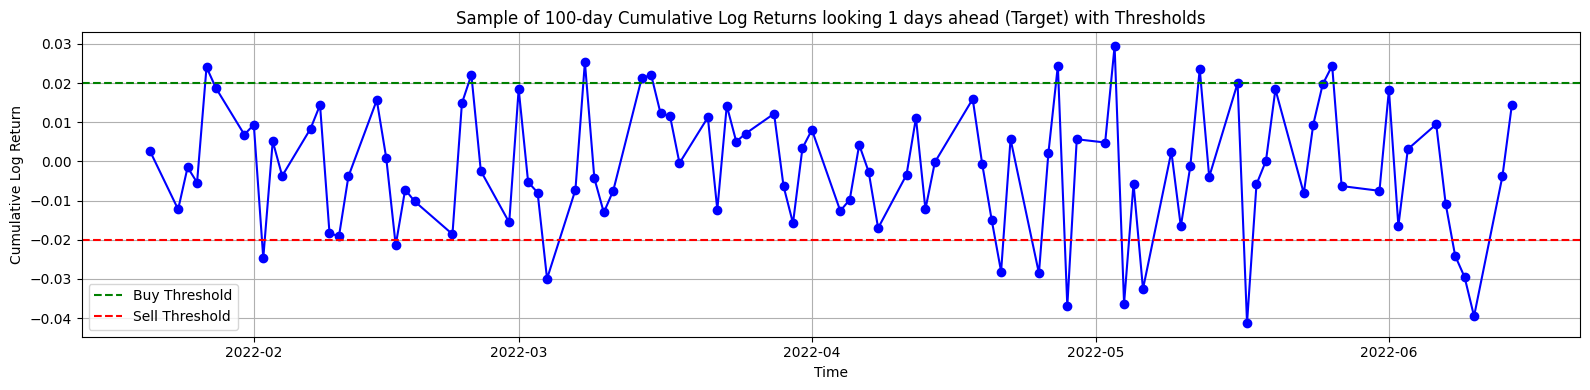

In [14]:
# Take a small sample (e.g. 100 points near the end)
sample = df_ta['Target'].iloc[-200:-100]
plt.figure(figsize=(16,4))
plt.plot(sample.index, sample.values, marker='o', linestyle='-', color='blue')
plt.axhline(0.02, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(-0.02, color='red', linestyle='--', label='Sell Threshold')
plt.title(f"Sample of 100-day Cumulative Log Returns looking {HORIZON} days ahead (Target) with Thresholds")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/107097662.py:39: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




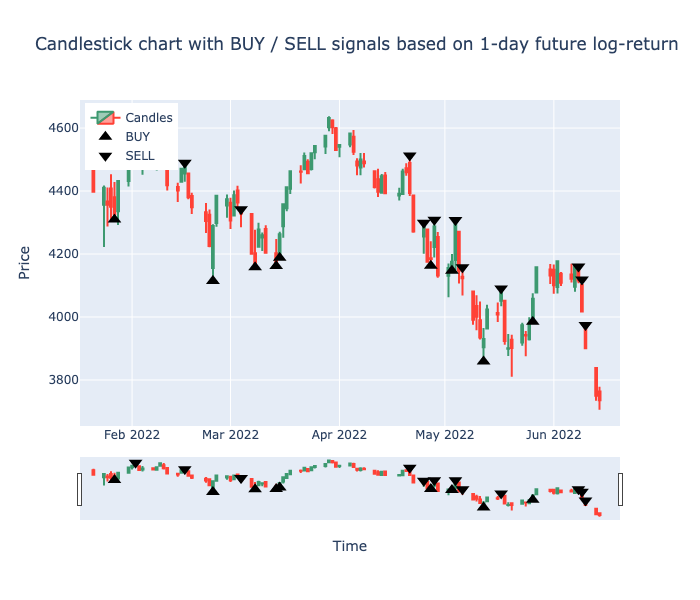

In [15]:
# Take a small sample (e.g. 100 points near the end)
df_slice = df_ta.iloc[-200:-100].copy()
# Identify signals
buy_signals = df_slice[df_slice['Target'] > 0.02]
sell_signals = df_slice[df_slice['Target'] < -0.02]
# Create candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df_slice.index,   # use index for x-axis
    open=df_slice['Open'],
    high=df_slice['High'],
    low=df_slice['Low'],
    close=df_slice['Close'],
    name='Candles'
)])
# BUY signals (triangle-up)
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Low'],  # anchor near candle low
    mode='markers', 
    marker=dict(symbol='triangle-up', size=12, color='black'), 
    name='BUY'
))
# SELL signals (triangle-down)
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['High'],  # anchor near candle high
    mode='markers', 
    marker=dict(symbol='triangle-down', size=12, color='black'),
    name='SELL'
))
fig.update_layout(
    title=f"Candlestick chart with BUY / SELL signals based on {HORIZON}-day future log-return",
    xaxis_title="Time", 
    yaxis_title="Price", 
    height=600,
    legend=dict(x=0.01, y=0.99)
)
path = "lstm_last_test_sample.png"
fig.write_image(path)
fig.show()
display(Image(filename=path)) # Display static image (GitHub-compatible)

# Data preprocessing

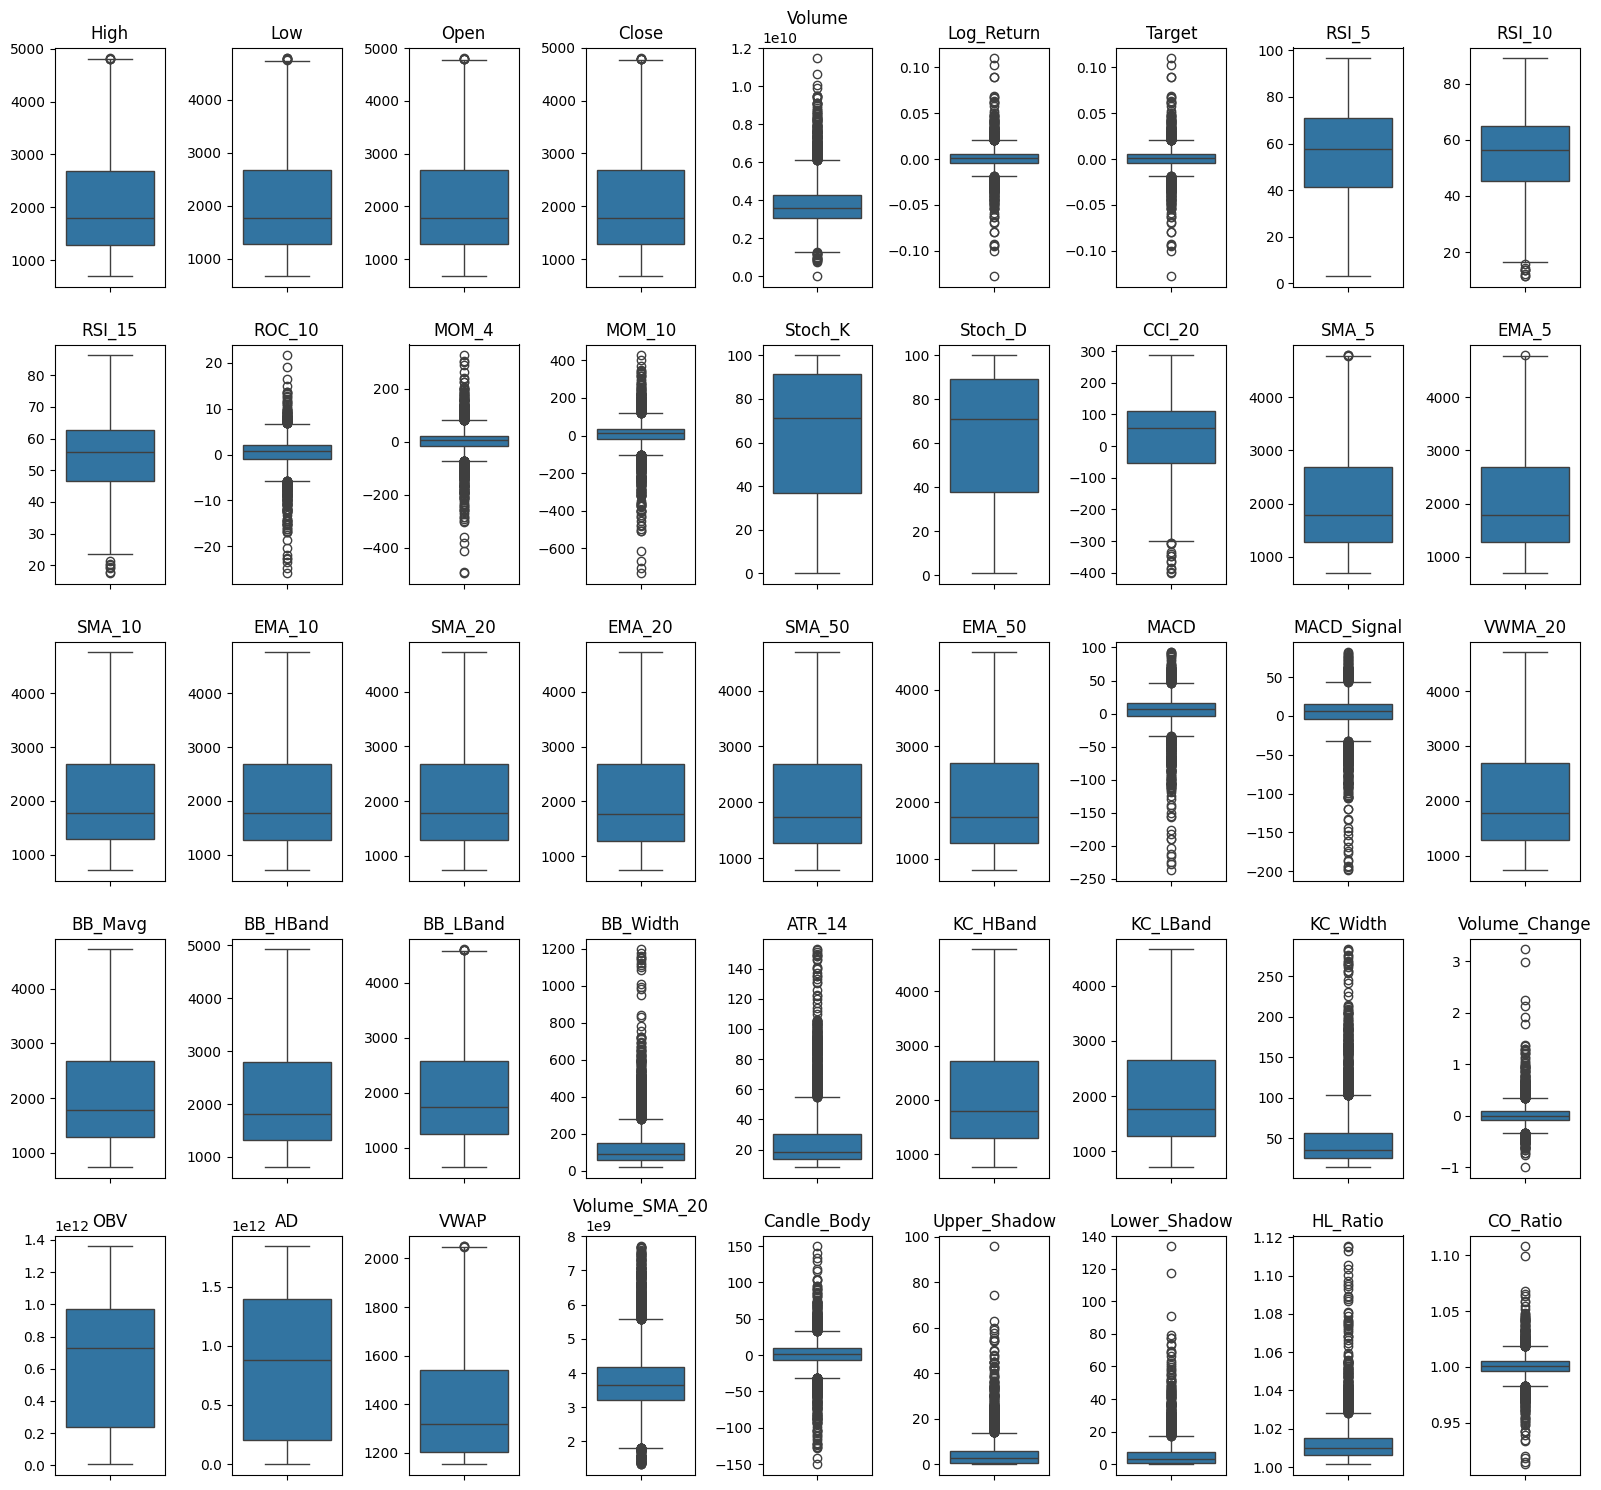

In [16]:
num_cols = 9
num_features = len(df_ta.columns)  
num_rows = math.ceil(num_features / num_cols)  
fig = plt.figure(figsize=(16, num_rows * 3))  
for i, x in enumerate(df_ta.columns, start=1):  
    plt.subplot(num_rows, num_cols, i)  
    ax = sns.boxplot(df_ta[x])  
    ax.set(xlabel=None)  
    plt.title(str(x), loc='center')  
    plt.xlabel(None)  
    plt.ylabel(None)  
plt.tight_layout()  
plt.show()

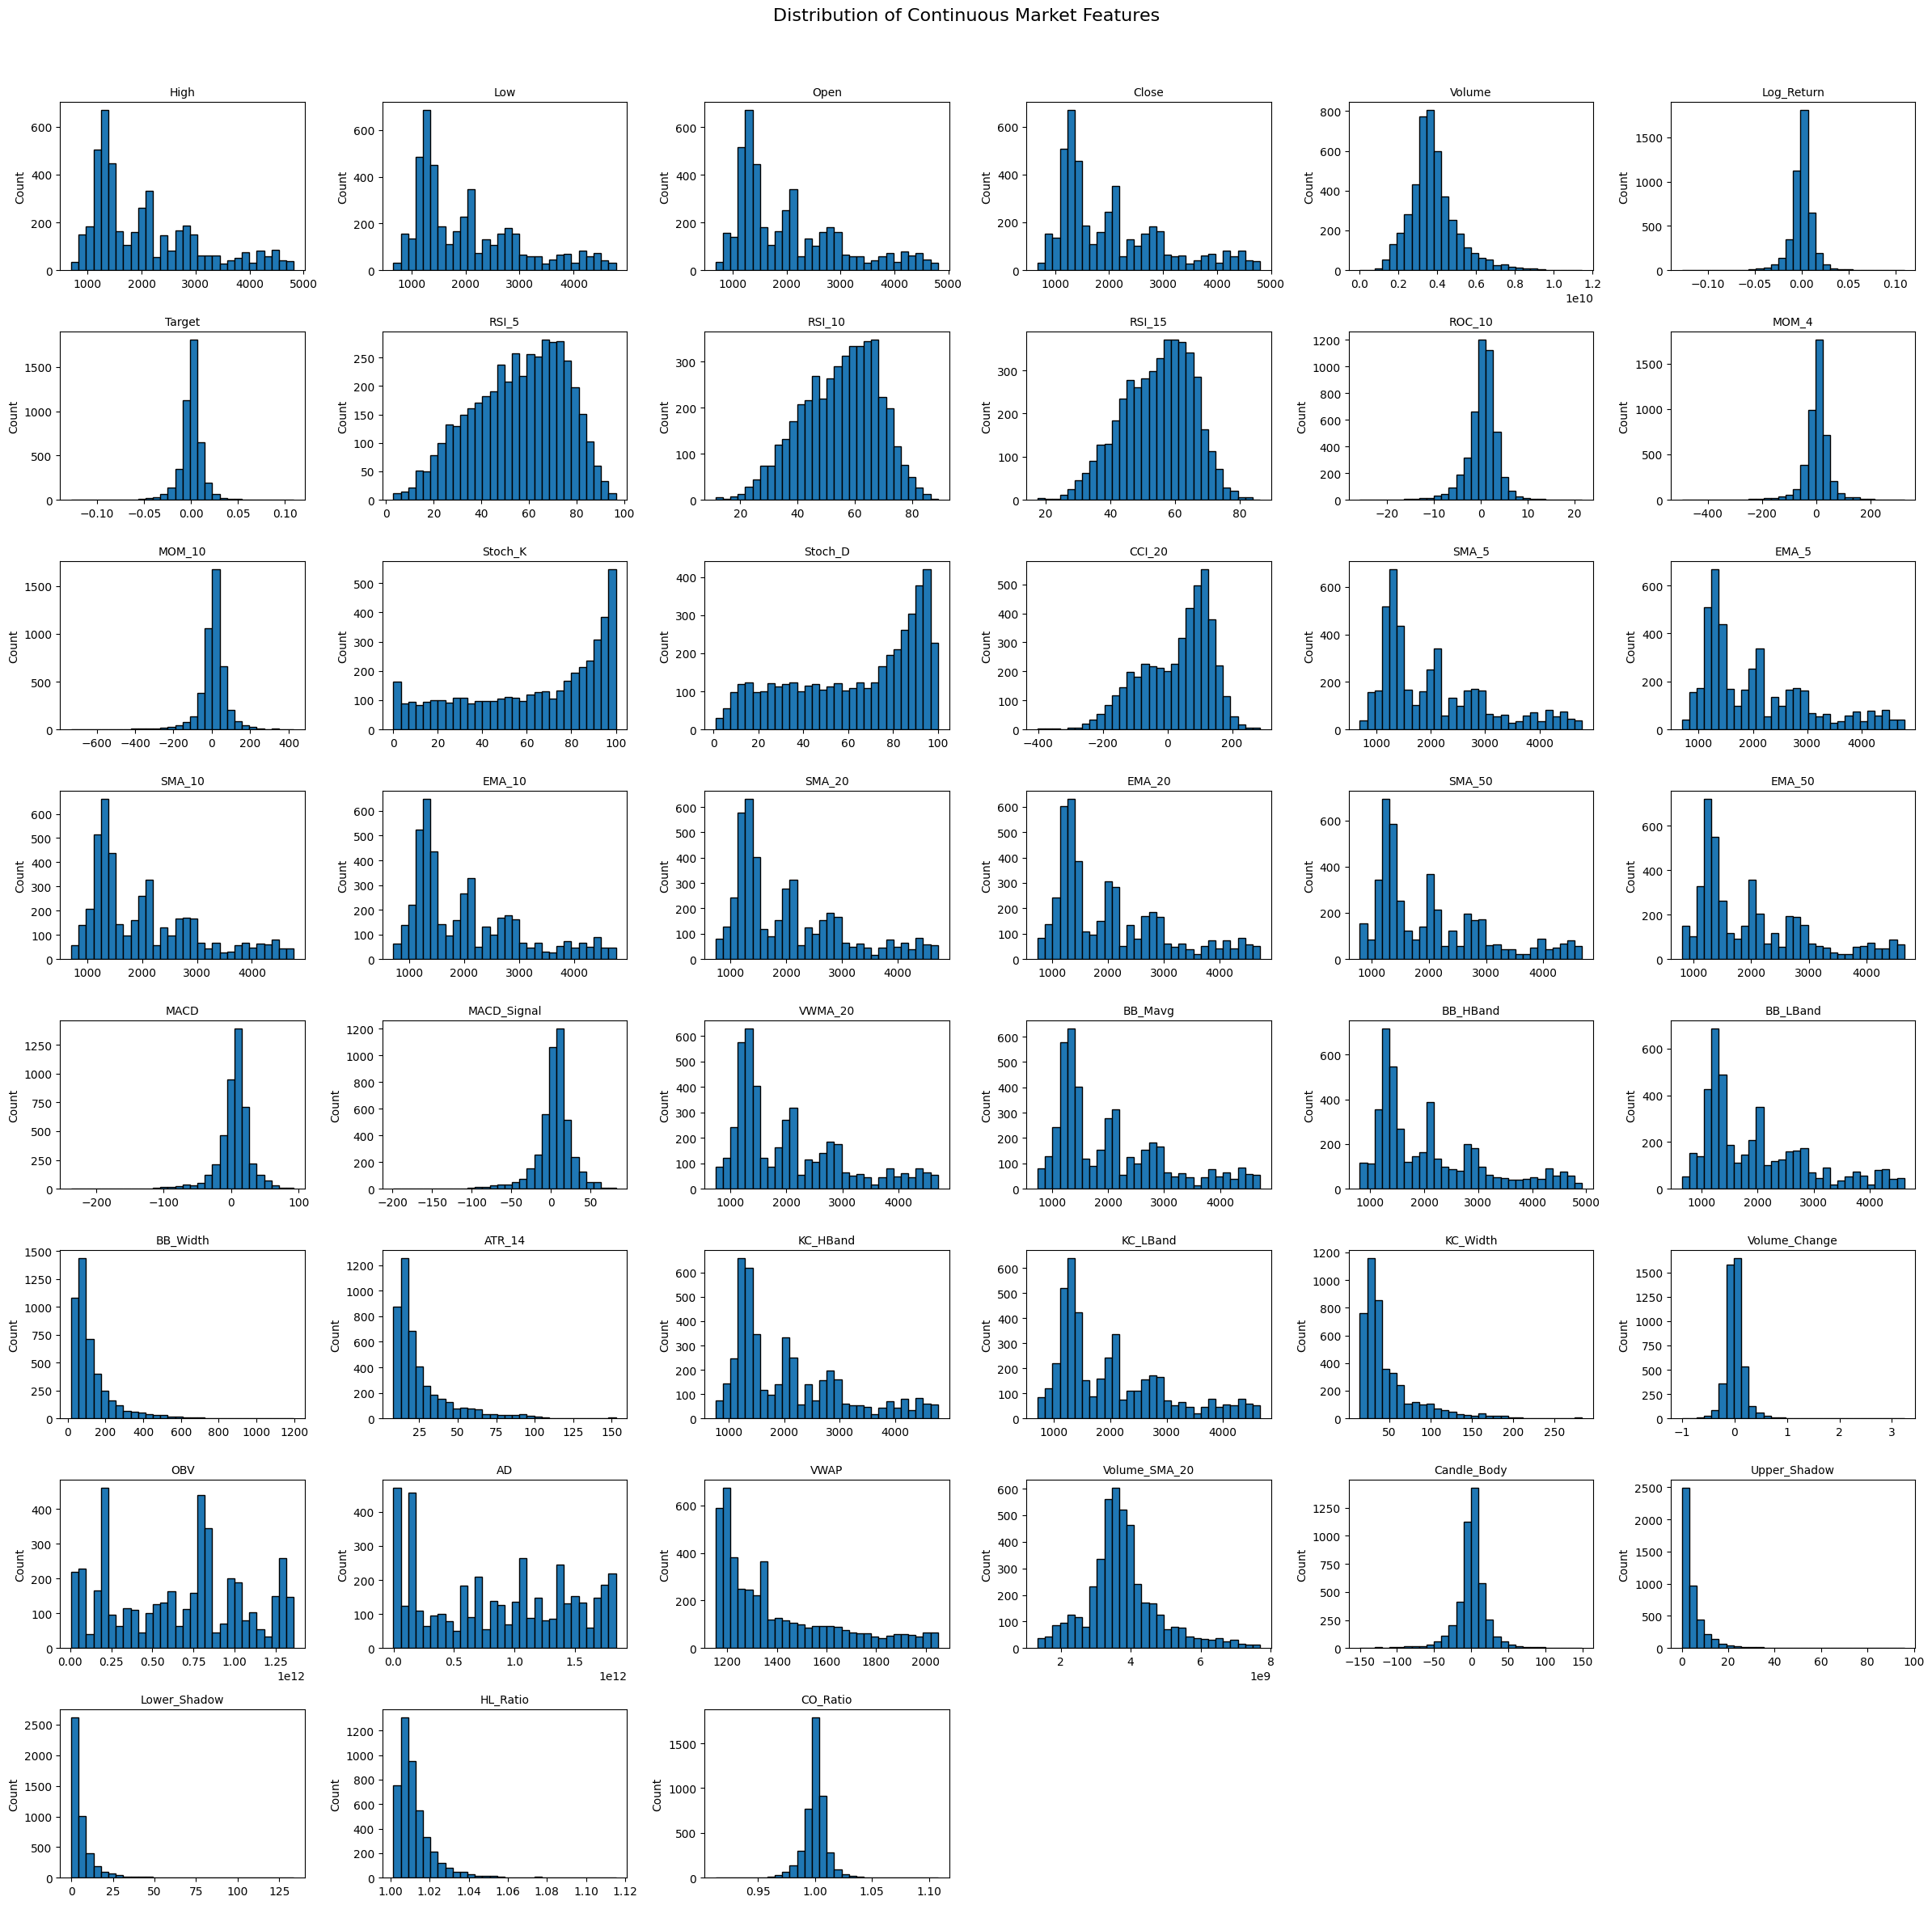

In [17]:
num_cols = 6
num_features = len(df_ta.columns)  
num_rows = math.ceil(num_features / num_cols)  
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4 * num_cols, 3 * num_rows))
axes = axes.flatten()
for i, col in enumerate(df_ta.columns):
    axes[i].hist(df_ta[col].dropna(),bins=30,edgecolor="black")
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
for j in range(i + 1, len(axes)):  # Remove unused axes
    fig.delaxes(axes[j])
plt.suptitle("Distribution of Continuous Market Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Feature Selection

In [18]:
df_ta.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Log_Return', 'Target',
       'RSI_5', 'RSI_10', 'RSI_15', 'ROC_10', 'MOM_4', 'MOM_10', 'Stoch_K',
       'Stoch_D', 'CCI_20', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20',
       'EMA_20', 'SMA_50', 'EMA_50', 'MACD', 'MACD_Signal', 'VWMA_20',
       'BB_Mavg', 'BB_HBand', 'BB_LBand', 'BB_Width', 'ATR_14', 'KC_HBand',
       'KC_LBand', 'KC_Width', 'Volume_Change', 'OBV', 'AD', 'VWAP',
       'Volume_SMA_20', 'Candle_Body', 'Upper_Shadow', 'Lower_Shadow',
       'HL_Ratio', 'CO_Ratio'],
      dtype='object')

In [19]:
# ===============================
# Train‑test split (time‑series aware)
# ===============================
# Use chronological split: 80% train (CV for validation), 20% test
split_idx = int(len(df_ta) * 0.6)
split_idx_val = int(len(df_ta) * 0.8)
train_df, val_df, test_df = df_ta.iloc[:split_idx].copy(), df_ta.iloc[split_idx:split_idx_val].copy(), df_ta.iloc[split_idx_val:].copy()

feature_cols = [c for c in df_ta.columns if c not in ["Open","High","Low","Close","Adj Close","Volume"] and not c.startswith("label_")]
print("Total features:", len(feature_cols))

Total features: 40


In [20]:
# ===============================
# Scale the data
# ===============================
feature_cols = ['High', 'Low', 'Open', 'Close', 'Volume', 'Log_Return',
                'RSI_5', 'RSI_10', 'RSI_15', 'ROC_10', 'MOM_4', 'MOM_10', 'Stoch_K',
                'Stoch_D', 'CCI_20', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20',
                'EMA_20', 'SMA_50', 'EMA_50', 'MACD', 'MACD_Signal', 'VWMA_20',
                'BB_Mavg', 'BB_HBand', 'BB_LBand', 'BB_Width', 'ATR_14', 'KC_HBand',
                'KC_LBand', 'KC_Width', 'Volume_Change', 'OBV', 'AD', 'VWAP',
                'Volume_SMA_20', 'Candle_Body', 'Upper_Shadow', 'Lower_Shadow',
                'HL_Ratio', 'CO_Ratio'
            ]
df_scaled = df_ta.copy()
X_scalers = {}
for col in feature_cols:
    scaler = StandardScaler()
    train_df[col] = scaler.fit_transform(train_df[[col]])
    val_df[col] = scaler.transform(val_df[[col]])
    test_df[col] = scaler.transform(test_df[[col]])
    X_scalers[col] = scaler

y_scaler = StandardScaler()
train_df["Target"] = y_scaler.fit_transform(train_df[["Target"]])
val_df["Target"]  = y_scaler.transform(val_df[["Target"]])
test_df["Target"]  = y_scaler.transform(test_df[["Target"]])

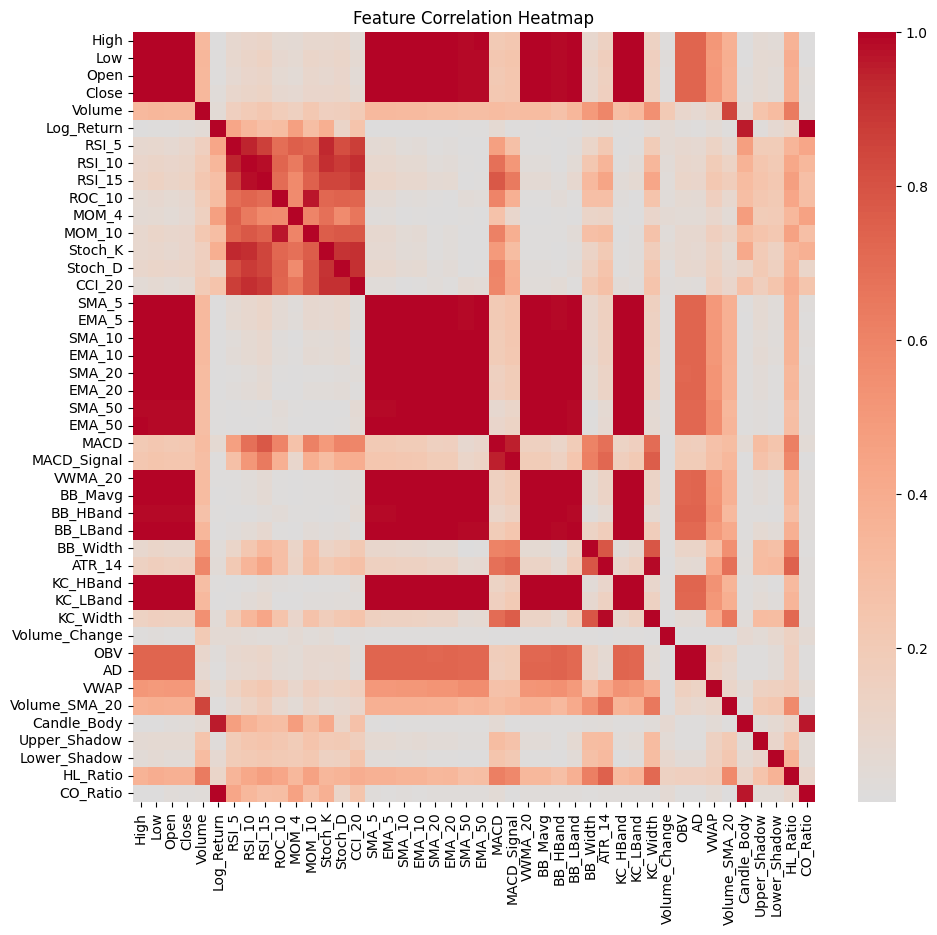

In [21]:
# ===============================
# Correlation Heatmap
# ===============================
plt.figure(figsize=(11, 10))
corr_matrix = train_df[feature_cols].corr().abs()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [22]:
# ===============================
# Highlighting the higly correlated features
# ===============================
threshold = 0.9
high_corr_pairs = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append((feature_cols[i], feature_cols[j], corr_value))

print("Highly correlated feature pairs (>|0.9|):")
for f1, f2, val in high_corr_pairs:
    print(f"{f1:11s}  <->  {f2:101s} : {val:.3f}")

Highly correlated feature pairs (>|0.9|):
High         <->  Low                                                                                                   : 0.999
High         <->  Open                                                                                                  : 1.000
High         <->  Close                                                                                                 : 1.000
High         <->  SMA_5                                                                                                 : 0.999
High         <->  EMA_5                                                                                                 : 1.000
High         <->  SMA_10                                                                                                : 0.998
High         <->  EMA_10                                                                                                : 0.999
High         <->  SMA_20                                      

In [23]:
# ===============================
# Looking for the columns to drop
# ===============================
to_drop = set()
for f1, f2, val in high_corr_pairs:
    if f2 not in to_drop:
        to_drop.add(f2)
print("Features to drop due to high correlation:")
print(sorted(to_drop))

feature_cols_reduced = [f for f in feature_cols if f not in to_drop]
print(f"{len(feature_cols)} original features:", )
print("Reduced features :", len(feature_cols_reduced))

Features to drop due to high correlation:
['AD', 'BB_HBand', 'BB_LBand', 'BB_Mavg', 'CCI_20', 'CO_Ratio', 'Candle_Body', 'Close', 'EMA_10', 'EMA_20', 'EMA_5', 'EMA_50', 'KC_HBand', 'KC_LBand', 'KC_Width', 'Low', 'MACD_Signal', 'MOM_10', 'Open', 'RSI_10', 'RSI_15', 'SMA_10', 'SMA_20', 'SMA_5', 'SMA_50', 'Stoch_D', 'Stoch_K', 'VWMA_20']
44 original features:
Reduced features : 16


In [24]:
# ===============================
# Pipeline to select the right indicators
# ===============================
"""
All indicators
   ↓
Variance threshold
   ↓
Correlation clustering
   ↓
Mutual information vs target
   ↓
XGBoost + SHAP
   ↓
Top 10-18 features
"""
"""
Variance:     Remove dead features
Clustering:	  Remove redundancy
Mutual Info:  Non-linear relevance
SHAP:         Model-aware importance
Stability:    Prevent overfitting
Lagging:      Time structure
"""

'\nVariance:     Remove dead features\nClustering:\t  Remove redundancy\nMutual Info:  Non-linear relevance\nSHAP:         Model-aware importance\nStability:    Prevent overfitting\nLagging:      Time structure\n'

In [25]:
# ===============================
# Variance threshold (1)
# ===============================
X = train_df[feature_cols].copy()
results = []
for th in [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-1, 1e-1]:
    vt = VarianceThreshold(threshold=th)
    X_vt = vt.fit(X)
    kept_ratio = vt.get_support().mean()
    
    results.append({
        "threshold": th,
        "kept_ratio": kept_ratio,
        "kept_features": np.sum(vt.get_support())
    })

vt_results = pd.DataFrame(results)
vt_results

,threshold,kept_ratio,kept_features
0,0.00001,1.0,44
1,0.00005,1.0,44
2,0.00010,1.0,44
3,0.00050,1.0,44
4,0.00100,1.0,44
5,0.00500,1.0,44
6,0.01000,1.0,44
7,0.50000,1.0,44
8,0.10000,1.0,44


In [26]:
# ===============================
# Variance threshold (2)
# ===============================
# Desired range
LOW, HIGH = 0.60, 0.80
valid = vt_results[
    (vt_results.kept_ratio >= LOW) &
    (vt_results.kept_ratio <= HIGH)
]

if valid.empty:
    print("No VarianceThreshold keeps 60-80% of features")
else:
    # pick the most aggressive (largest threshold)
    best_row = valid.sort_values("threshold", ascending=False).iloc[0]
    best_threshold = best_row["threshold"]
    print(f"Selected VarianceThreshold = {best_threshold}")
    print(f"Kept ratio = {best_row['kept_ratio']:.2f}")
    vt = VarianceThreshold(threshold=best_threshold)
    X_vt = vt.fit_transform(X)
    vt_features = [f for f, keep in zip(feature_cols, vt.get_support()) if keep]
    print("Features kept after VarianceThreshold:")
    print(vt_features)
    print(f"Total kept: {len(vt_features)} / {len(feature_cols)}")

No VarianceThreshold keeps 60-80% of features


In [27]:
# ===============================
# Correlation clustering
# ===============================
# Correlation between kept features
corr = train_df[feature_cols].corr().abs()
# Convert correlation to distance
distance = 1 - corr
# Condensed distance matrix required by linkage
condensed_distance = squareform(distance.values, checks=False)
# Build linkage matrix
linkage = sch.linkage(condensed_distance, method='ward')   # or 'average'
# Create clusters 
clusters = sch.fcluster(linkage, t=0.2, criterion='distance')
cluster_df = pd.DataFrame({"feature": feature_cols, "cluster": clusters})

# Select best feature per cluster (target-aware)
selected_corr_features = []
for cl in cluster_df.cluster.unique():
    feats = cluster_df[cluster_df.cluster == cl]["feature"].tolist()
    # Choose feature most correlated with target
    best = max(feats, key=lambda f: abs(train_df[f].corr(train_df["Target"])))
    selected_corr_features.append(best)

print("After correlation clustering:", len(selected_corr_features))
print(selected_corr_features)

After correlation clustering: 15
['Close', 'Volume_SMA_20', 'CO_Ratio', 'RSI_5', 'ROC_10', 'MOM_4', 'MACD', 'BB_Width', 'KC_Width', 'Volume_Change', 'AD', 'VWAP', 'Upper_Shadow', 'Lower_Shadow', 'HL_Ratio']


In [28]:
# ===============================
# Mutual information vs target (1)
# ===============================
mi = mutual_info_regression(train_df[selected_corr_features], train_df['Target'])
mi_scores = pd.Series(mi, index=selected_corr_features).sort_values(ascending=False)
mi_scores.head(20)  # visualize cutoff

KC_Width         0.138454
HL_Ratio         0.100760
RSI_5            0.096636
ROC_10           0.076886
MACD             0.075995
AD               0.075990
Volume_SMA_20    0.075651
BB_Width         0.073372
Close            0.065250
MOM_4            0.042975
Lower_Shadow     0.033281
CO_Ratio         0.027729
VWAP             0.015099
Volume_Change    0.000000
Upper_Shadow     0.000000
dtype: float64

In [29]:
# ===============================
# Mutual information vs target (2)
# ===============================
mi_threshold = mi_scores.quantile(0.2)  # keep top 80%
selected_mi_features = mi_scores[mi_scores > mi_threshold].index.tolist()
print("After MI filtering:", len(selected_mi_features))
print(selected_mi_features)

After MI filtering: 12
['KC_Width', 'HL_Ratio', 'RSI_5', 'ROC_10', 'MACD', 'AD', 'Volume_SMA_20', 'BB_Width', 'Close', 'MOM_4', 'Lower_Shadow', 'CO_Ratio']


PermutationExplainer explainer: 2704it [02:13, 19.10it/s]                          

Final features: ['Close', 'Volume_SMA_20', 'ROC_10', 'MACD', 'RSI_5', 'KC_Width', 'Lower_Shadow', 'AD', 'HL_Ratio', 'MOM_4', 'CO_Ratio', 'BB_Width']


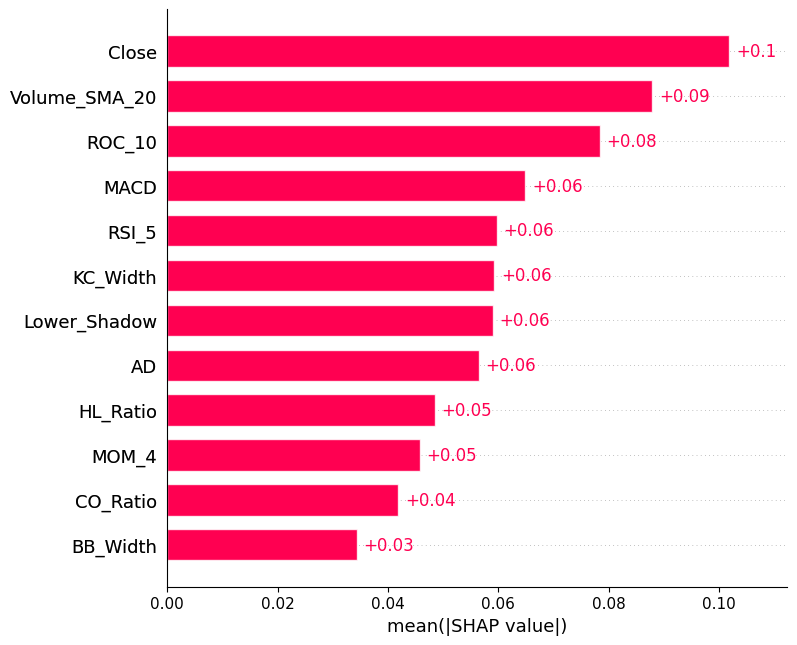

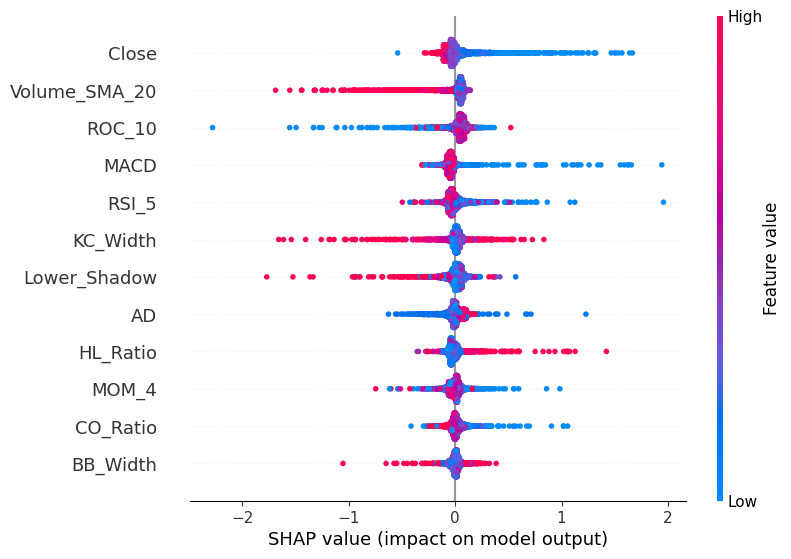

In [30]:
# ===============================
# Gradient boosting model to select features based on shap and importance
# ===============================
model = XGBRegressor(n_estimators=400, max_depth=5, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8, random_state=42)
model.fit(train_df[selected_mi_features], train_df['Target'])
explainer = shap.Explainer(model.predict, train_df[selected_mi_features])
shap_values = explainer(train_df[selected_mi_features])

# Compute global importance
shap_importance = shap_values.abs.mean(0)  # mean absolute SHAP values per feature
shap_features = pd.Series(shap_importance.values, index=selected_mi_features).sort_values(ascending=False)
final_features = shap_features.head(12).index.tolist()
print("Final features:", final_features)

# Global importance plot
shap.plots.bar(shap_values, max_display=12)
# Distribution of SHAP values
shap.plots.beeswarm(shap_values, max_display=12)

In [31]:
# ===============================
# Dropping the columns 
# ===============================
feature_cols = [
    # ── Core price dynamics ─────────────────────────
    'Close',
    'Log_Return',          # primary predictive signal
    'ATR_14',              # volatility regime
    'HL_Ratio',            # intraday range
    'Upper_Shadow',
    'Lower_Shadow',
    
    # ── Momentum / oscillators ──────────────────────
    'RSI_5',               # one RSI only
    'MOM_4',               # momentum over short periods
    'MOM_10',              # momentum over medium periods
    'Stoch_K',             # momentum position
    'MACD',                # trend momentum (keep signal OR macd, not both)

    # ── Trend (derived, not raw) ────────────────────
    'BB_Width',            # BB_HBand - BB_LBand  (create this)
    'KC_Width',            # KC_HBand - KC_LBand  (create this)

    # ── Volume ──────────────────────────────────────
    'Volume',              # raw participation
    'OBV',                 # cumulative pressure
    'Volume_Change',       # (volume pct_change)

    # ── Price structure ─────────────────────────────
    'AD',                  # accumulation/distribution
    'VWAP'                 # institutional anchor
]
selected_cols = feature_cols + ["Target"]
train_df = train_df[selected_cols]
test_df = test_df[selected_cols]

# Data creation

In [32]:
# ===============================
# Build Sequences 
# ===============================
def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X.iloc[i-seq_len:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 10
X_train_seq, y_train_seq = make_sequences(train_df[feature_cols], train_df["Target"], SEQ_LEN)
X_val_seq, y_val_seq = make_sequences(val_df[feature_cols], val_df["Target"], SEQ_LEN)
X_test_seq, y_test_seq = make_sequences(test_df[feature_cols], test_df["Target"], SEQ_LEN)

# Create and train the Tensorflow model 

In [33]:
# ===============================
# Create the model 
# ===============================
def build_lstm_regressor(seq_len, n_features, units=64, dropout=0.3):
    inp = layers.Input(shape=(seq_len, n_features))
    
    x = layers.LSTM(units, return_sequences=True)(inp)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)
    
    x = layers.LSTM(units // 2)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)
    
    out = layers.Dense(1)(x)  # regression output
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=["mae"]
    )
    
    return model

# Model parameters
N_FEATURES = X_train_seq.shape[2]
tf_model = build_lstm_regressor(SEQ_LEN, N_FEATURES)
tf_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 10, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,889 (132.38 KB)

 Trainable params: 33,889 (132.38 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# ===============================
# Create the model 
# ===============================
history = tf_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=64
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1.8057 - mae: 0.9823 - val_loss: 0.7217 - val_mae: 0.6173
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.4084 - mae: 0.8396 - val_loss: 0.7378 - val_mae: 0.7011
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.2541 - mae: 0.7764 - val_loss: 0.6242 - val_mae: 0.6189
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.1608 - mae: 0.7245 - val_loss: 0.5667 - val_mae: 0.5670
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.1055 - mae: 0.7116 - val_loss: 0.5568 - val_mae: 0.5666
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0862 - mae: 0.6938 - val_loss: 0.5065 - val_mae: 0.5166
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0736 - mae: 0.6879 - val_loss: 0.5006 - val_mae: 0.5144
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0277 - mae: 0.6649 - val_loss: 0.4957 - val_mae: 0.5102
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.027

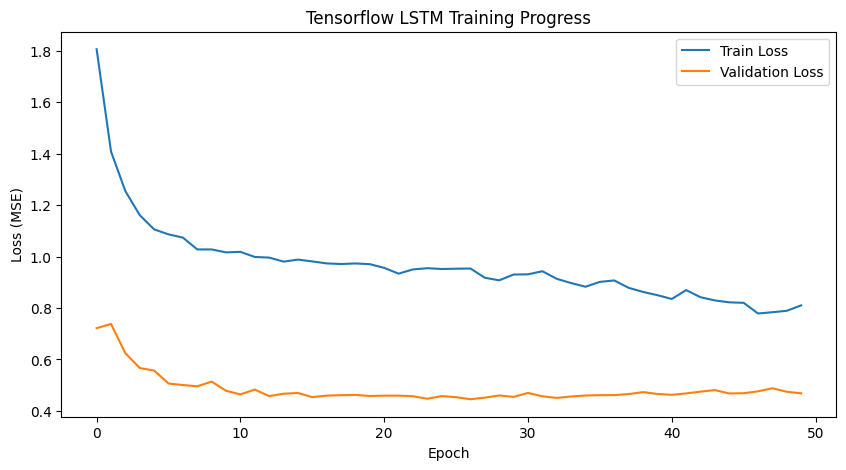

In [35]:
# ===============================
# Plot loss functions
# ===============================
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Tensorflow LSTM Training Progress')
plt.legend()
plt.show()

In [36]:
# ===============================
# Prediction & Evaluation
# ===============================
y_pred = tf_model.predict(X_test_seq).flatten()
print(y_pred[:5])
print(y_test_seq[:5])

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[-0.18459968 -0.20367412 -0.20817116 -0.18257722 -0.2092306 ]
[ 0.35449414  0.07033648  0.06087479 -0.60795367 -0.18178826]


In [37]:
# ===============================
# Vizualisations
# ===============================

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/4047035504.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/4047035504.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/4047035504.py:38: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




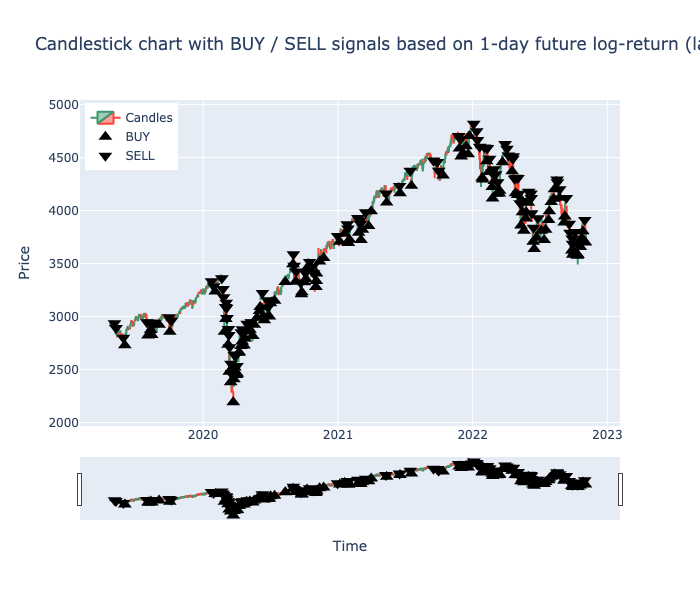

In [38]:
df_slice = df_ta.iloc[split_idx_val+SEQ_LEN:].copy()
# Identify signals
buy_signals = df_slice[test_df['Target'] > 1]
sell_signals = df_slice[test_df['Target'] < -1]
# Create candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df_slice.index,   # use index for x-axis
    open=df_slice['Open'],
    high=df_slice['High'],
    low=df_slice['Low'],
    close=df_slice['Close'],
    name='Candles'
)])
# BUY signals (triangle-up)
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Low'],  # anchor near candle low
    mode='markers', 
    marker=dict(symbol='triangle-up', size=12, color='black'), 
    name='BUY'
))
# SELL signals (triangle-down)
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['High'],  # anchor near candle high
    mode='markers', 
    marker=dict(symbol='triangle-down', size=12, color='black'),
    name='SELL'
))
fig.update_layout(
    title=f"Candlestick chart with BUY / SELL signals based on {HORIZON}-day future log-return (labelling)",
    xaxis_title="Time", 
    yaxis_title="Price", 
    height=600,
    legend=dict(x=0.01, y=0.99)
)
path = "lstm_full_test_true_tensorflow.png"
fig.write_image(path)
fig.show()
display(Image(filename=path)) # Display static image (GitHub-compatible)

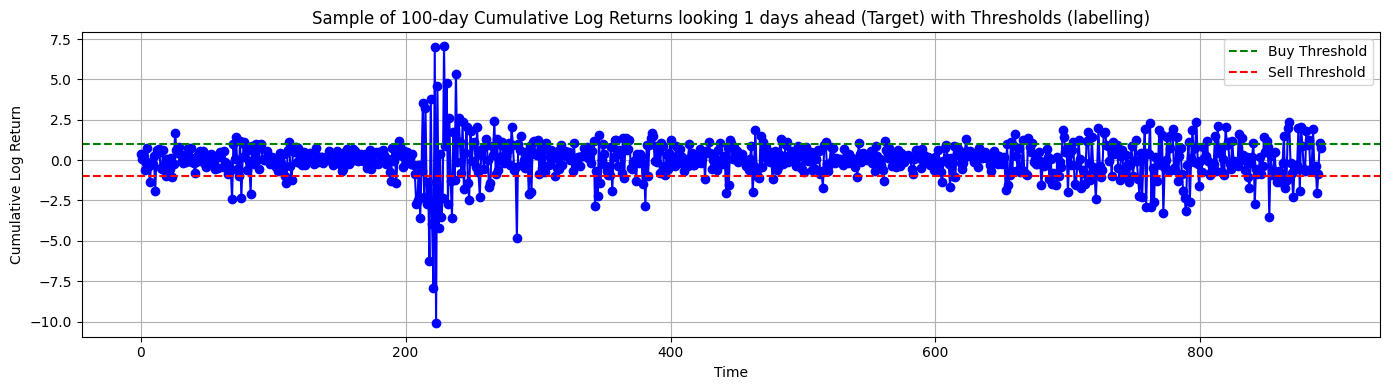

In [39]:
plt.figure(figsize=(14,4))
plt.plot(y_test_seq, marker='o', linestyle='-', color='blue')
plt.axhline(1, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(-1, color='red', linestyle='--', label='Sell Threshold')
plt.title(f"Sample of 100-day Cumulative Log Returns looking {HORIZON} days ahead (Target) with Thresholds (labelling)")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

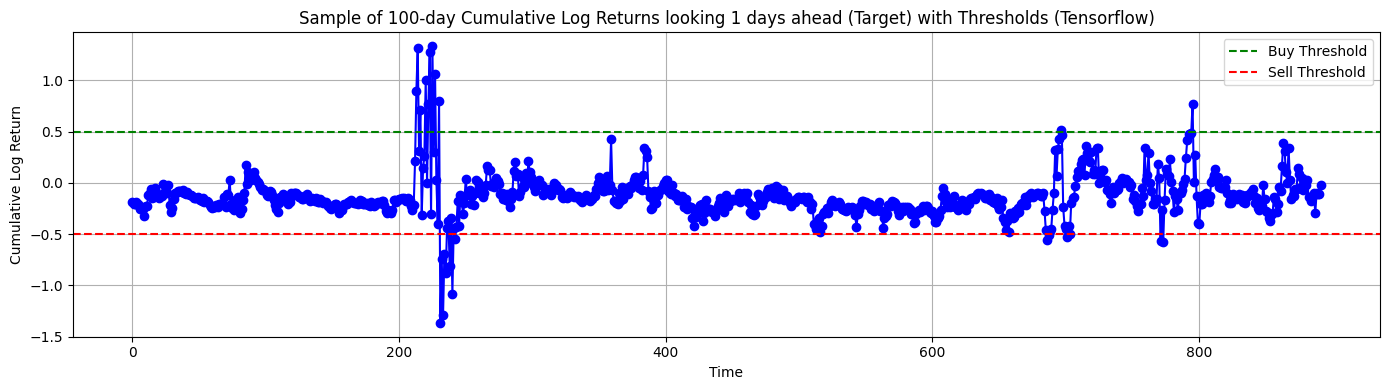

In [40]:
plt.figure(figsize=(14,4))
plt.plot(y_pred, marker='o', linestyle='-', color='blue')
plt.axhline(0.5, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(-0.5, color='red', linestyle='--', label='Sell Threshold')
plt.title(f"Sample of 100-day Cumulative Log Returns looking {HORIZON} days ahead (Target) with Thresholds (Tensorflow)")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/2713706467.py:41: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




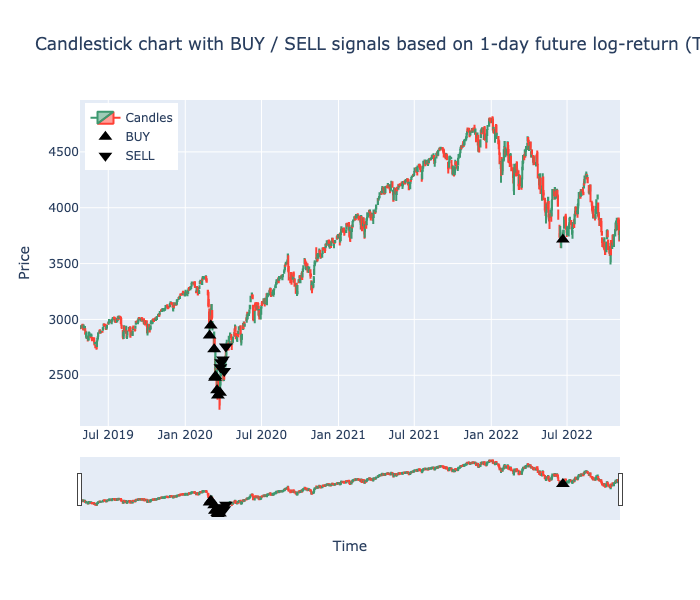

In [41]:
df_slice = df_ta.iloc[split_idx_val+SEQ_LEN:].copy()
y_pred_slice = y_pred[-len(df_slice):]  # make sure lengths match
df_slice = df_slice.copy()
df_slice["y_pred"] = y_pred_slice
# Identify signals
buy_signals = df_slice[df_slice["y_pred"] > 0.75]
sell_signals = df_slice[df_slice["y_pred"] < -0.75]
# Create candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df_slice.index,   # use index for x-axis
    open=df_slice['Open'],
    high=df_slice['High'],
    low=df_slice['Low'],
    close=df_slice['Close'],
    name='Candles'
)])
# BUY signals (triangle-up)
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Low'],  # anchor near candle low
    mode='markers', 
    marker=dict(symbol='triangle-up', size=12, color='black'), 
    name='BUY'
))
# SELL signals (triangle-down)
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['High'],  # anchor near candle high
    mode='markers', 
    marker=dict(symbol='triangle-down', size=12, color='black'),
    name='SELL'
))
fig.update_layout(
    title=f"Candlestick chart with BUY / SELL signals based on {HORIZON}-day future log-return (Tensorflow)",
    xaxis_title="Time", 
    yaxis_title="Price", 
    height=600,
    legend=dict(x=0.01, y=0.99)
)
path = "lstm_full_test_pred_tensorflow.png"
fig.write_image(path)
fig.show()
display(Image(filename=path)) # Display static image (GitHub-compatible)

# Create and train the Pytorch model 

In [42]:
# ===============================
# Build PyTorch compatible data
# ===============================
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

BATCH_SIZE = 64
train_dataset = SequenceDataset(X_train_seq, y_train_seq)
val_dataset  = SequenceDataset(X_test_seq, y_test_seq)
test_dataset  = SequenceDataset(X_test_seq, y_test_seq)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) #, drop_last=True) # sequences shuffling 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
# ===============================
# LSTM Regressor 
# ===============================
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, units=64, dropout=0.3, use_layernorm=True):
        super().__init__()
        self.use_layernorm = use_layernorm

        # First LSTM layer (return sequences)
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=units, batch_first=True)
        self.ln1 = nn.LayerNorm(units) if use_layernorm else nn.Identity()
        self.drop1 = nn.Dropout(dropout)

        # Second LSTM layer (last output)
        self.lstm2 = nn.LSTM(input_size=units, hidden_size=units//2, batch_first=True)
        self.ln2 = nn.LayerNorm(units//2) if use_layernorm else nn.Identity()
        self.drop2 = nn.Dropout(dropout)

        # Output
        self.fc = nn.Linear(units//2, 1)

        # Initialization like Keras
        for lstm in [self.lstm1, self.lstm2]:
            for name, param in lstm.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        out, _ = self.lstm1(x)
        out = self.drop1(self.ln1(out))
        out, _ = self.lstm2(out)
        out = self.drop2(self.ln2(out))
        out = out[:, -1, :]  # take last timestep
        out = self.fc(out)
        return out.squeeze(-1)

In [44]:
# ===============================
# Train function
# ===============================
def train_model(
    model,
    train_loader,
    val_loader,
    epochs: int = 30,
    lr: float = 1e-3,
    weight_decay: float = 0.0,
    device: str = "cpu"
):
    model.to(device)
    optimizer = torch.optim.AdamW( model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss() # nn.HuberLoss(delta=1.0)

    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        train_loss = 0.0
        model.train()

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb)
                val_loss += criterion(preds, yb).item()
            val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

In [45]:
# ===============================
# Running it
# ===============================
device = torch.device("cpu")
torch.set_num_threads(1)   # extra safety on macOS
torch_model = LSTMRegressor(n_features=len(feature_cols), units=128, dropout=0.3, use_layernorm=True)
train_losses, val_losses = train_model(torch_model, train_loader, val_loader=val_loader, epochs=75, lr=1e-3, device=device)

Epoch 01 | Train Loss: 1.2523 | Val Loss: 1.8406
Epoch 02 | Train Loss: 1.1112 | Val Loss: 1.4217
Epoch 03 | Train Loss: 1.0904 | Val Loss: 1.4659
Epoch 04 | Train Loss: 1.0445 | Val Loss: 1.4329
Epoch 05 | Train Loss: 1.0405 | Val Loss: 1.4386
Epoch 06 | Train Loss: 1.0569 | Val Loss: 1.4485
Epoch 07 | Train Loss: 1.0366 | Val Loss: 1.4121
Epoch 08 | Train Loss: 1.0171 | Val Loss: 1.4157
Epoch 09 | Train Loss: 0.9875 | Val Loss: 1.4257
Epoch 10 | Train Loss: 0.9876 | Val Loss: 1.4275
Epoch 11 | Train Loss: 0.9796 | Val Loss: 1.4387
Epoch 12 | Train Loss: 0.9851 | Val Loss: 1.4524
Epoch 13 | Train Loss: 0.9762 | Val Loss: 1.4463
Epoch 14 | Train Loss: 0.9479 | Val Loss: 1.4659
Epoch 15 | Train Loss: 0.9380 | Val Loss: 1.4840
Epoch 16 | Train Loss: 0.9422 | Val Loss: 1.5112
Epoch 17 | Train Loss: 0.9409 | Val Loss: 1.5368
Epoch 18 | Train Loss: 0.9410 | Val Loss: 1.5147
Epoch 19 | Train Loss: 0.9443 | Val Loss: 1.5421
Epoch 20 | Train Loss: 0.9328 | Val Loss: 1.5022
Epoch 21 | Train Los

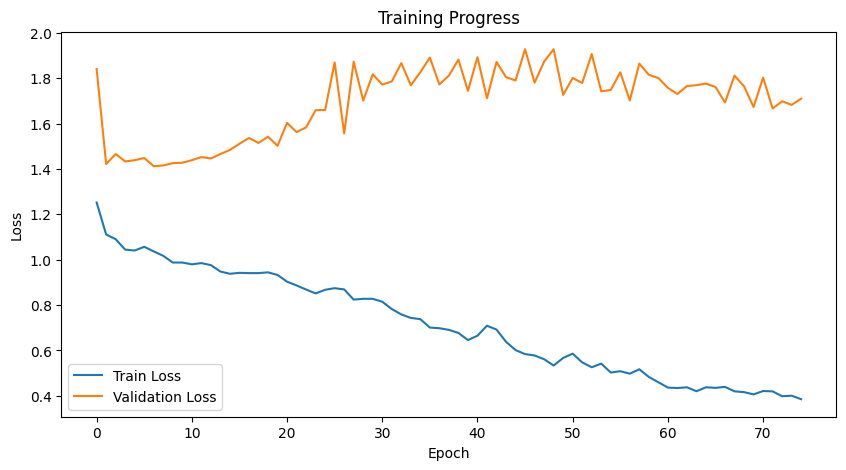

In [46]:
# ===============================
# Plot loss functions
# ===============================
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Progress")
plt.legend()
plt.show()

In [47]:
# ===============================
# Prediction & Evaluation
# ===============================
torch_model.eval()
preds = []
with torch.no_grad():  # disable gradient calculation
    for xb, _ in test_loader:
        xb = xb.float().to(device)
        out = torch_model(xb)
        preds.append(out.cpu().numpy())
# Concatenate all batches
y_pred = np.concatenate(preds).flatten()

In [48]:
# ===============================
# Vizualisations
# ===============================

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/1081712942.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/1081712942.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/1081712942.py:38: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




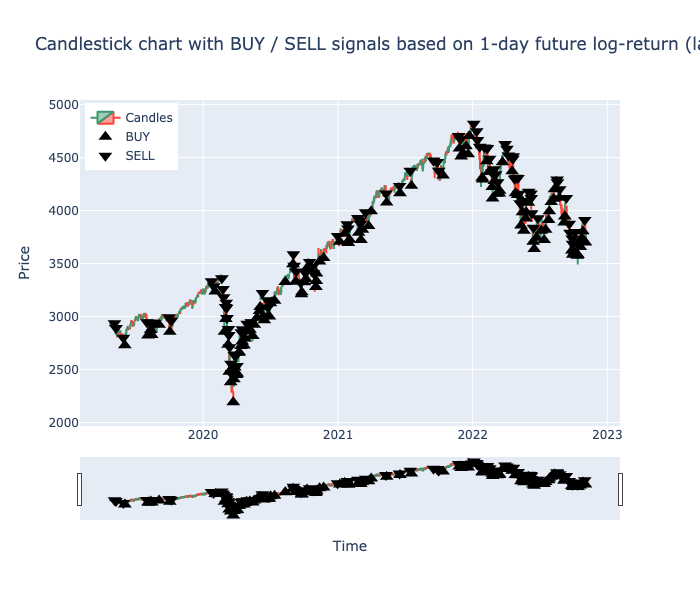

In [49]:
df_slice = df_ta.iloc[split_idx_val+SEQ_LEN:].copy()
# Identify signals
buy_signals = df_slice[test_df['Target'] > 1]
sell_signals = df_slice[test_df['Target'] < -1]
# Create candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df_slice.index,   # use index for x-axis
    open=df_slice['Open'],
    high=df_slice['High'],
    low=df_slice['Low'],
    close=df_slice['Close'],
    name='Candles'
)])
# BUY signals (triangle-up)
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Low'],  # anchor near candle low
    mode='markers', 
    marker=dict(symbol='triangle-up', size=12, color='black'), 
    name='BUY'
))
# SELL signals (triangle-down)
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['High'],  # anchor near candle high
    mode='markers', 
    marker=dict(symbol='triangle-down', size=12, color='black'),
    name='SELL'
))
fig.update_layout(
    title=f"Candlestick chart with BUY / SELL signals based on {HORIZON}-day future log-return (labelling)",
    xaxis_title="Time", 
    yaxis_title="Price", 
    height=600,
    legend=dict(x=0.01, y=0.99)
)
path = "lstm_full_test_true_pytorch.png"
fig.write_image(path)
fig.show()
display(Image(filename=path)) # Display static image (GitHub-compatible)

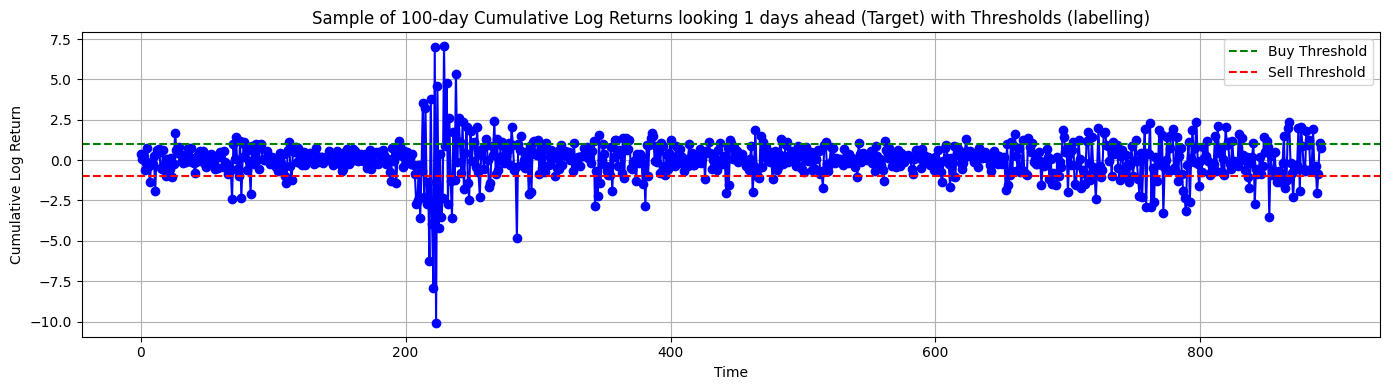

In [50]:
plt.figure(figsize=(14,4))
plt.plot(y_test_seq, marker='o', linestyle='-', color='blue')
plt.axhline(1, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(-1, color='red', linestyle='--', label='Sell Threshold')
plt.title(f"Sample of 100-day Cumulative Log Returns looking {HORIZON} days ahead (Target) with Thresholds (labelling)")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

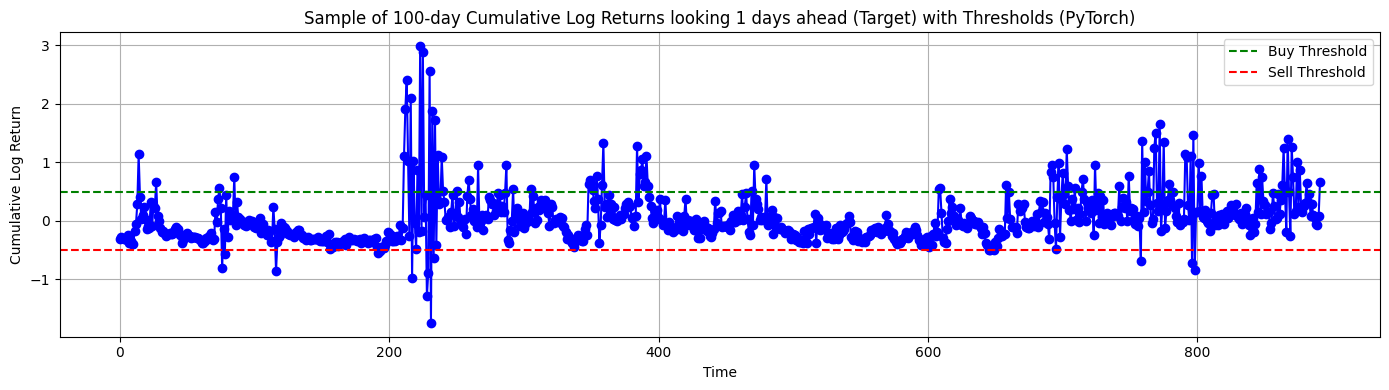

In [51]:
plt.figure(figsize=(14,4))
plt.plot(y_pred, marker='o', linestyle='-', color='blue')
plt.axhline(0.5, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(-0.5, color='red', linestyle='--', label='Sell Threshold')
plt.title(f"Sample of 100-day Cumulative Log Returns looking 1 days ahead (Target) with Thresholds (PyTorch)")
plt.xlabel("Time")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_52219/1859249748.py:41: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




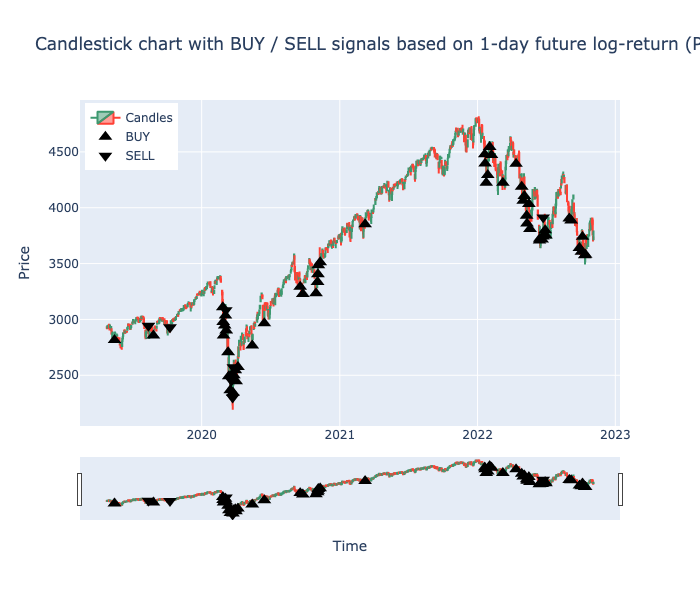

In [52]:
df_slice = df_ta.iloc[split_idx_val+SEQ_LEN:].copy()
y_pred_slice = y_pred[-len(df_slice):]  # make sure lengths match
df_slice = df_slice.copy()
df_slice["y_pred"] = y_pred_slice
# Identify signals
buy_signals = df_slice[df_slice["y_pred"] > 0.75]
sell_signals = df_slice[df_slice["y_pred"] < -0.75]
# Create candlestick figure
fig = go.Figure(data=[go.Candlestick(
    x=df_slice.index,   # use index for x-axis
    open=df_slice['Open'],
    high=df_slice['High'],
    low=df_slice['Low'],
    close=df_slice['Close'],
    name='Candles'
)])
# BUY signals (triangle-up)
fig.add_trace(go.Scatter(
    x=buy_signals.index,
    y=buy_signals['Low'],  # anchor near candle low
    mode='markers', 
    marker=dict(symbol='triangle-up', size=12, color='black'), 
    name='BUY'
))
# SELL signals (triangle-down)
fig.add_trace(go.Scatter(
    x=sell_signals.index,
    y=sell_signals['High'],  # anchor near candle high
    mode='markers', 
    marker=dict(symbol='triangle-down', size=12, color='black'),
    name='SELL'
))
fig.update_layout(
    title=f"Candlestick chart with BUY / SELL signals based on {HORIZON}-day future log-return (PyTorch)",
    xaxis_title="Time", 
    yaxis_title="Price", 
    height=600,
    legend=dict(x=0.01, y=0.99)
)
path = "lstm_full_test_pred_pytorch.png"
fig.write_image(path)
fig.show()
display(Image(filename=path)) # Display static image (GitHub-compatible)

In [53]:
# ===============================
# Optuna Hyperparameters Tuning 
# ===============================
# should be done for the final model, here we don't really care

In [54]:
mse = mean_squared_error(y_test_seq, y_pred)
mae = mean_absolute_error(y_test_seq, y_pred)
r2 = r2_score(y_test_seq, y_pred)
direction_acc = ((y_test_seq * y_pred) > 0).mean()
print(f"MSE: {mse:.5f}, MAE: {mae:.5f}, R2: {r2:.3f}, Direction Accuracy: {direction_acc:.3%}")

MSE: 1.71033, MAE: 0.82673, R2: -0.234, Direction Accuracy: 48.318%


In [55]:
# ===============================
# Predict action comparing predictions and thresholds
# ===============================
def get_positions(test, preds, thr_buy=0.75, thr_sell=-0.75):
    # Convert predicted cumulative log return into discrete actions: 0 = neutral, 1 = buy, -2 = sell
    y_pred_label = np.select(
        [preds > thr_buy, preds < thr_sell],
        [1, 2],  # 2=BUY, 1=SELL, 0=HOLD
        default=0
    )
    y_true_label = np.select(
        [test > thr_buy, test < thr_sell],
        [2, 1],
        default=0
    )
    return y_true_label, y_pred_label

y_true_label, y_pred_label = get_positions(y_test_seq, y_pred,  thr_buy=0.75, thr_sell=-0.75)
print("Analytics true:   ", y_true_label[:100])
print("Model predictions:", y_pred_label[:100])

Analytics true:    [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 2 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 2 0 2 0
 1 2 1 0 2 2 0 0 0 1 2 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0]
Model predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [56]:
# ===============================
# Full predictions classification report
# ===============================
print("----- Classification report -----")
print(classification_report(y_true_label, y_pred_label, digits=4))

summary = {
    "Accuracy"          : accuracy_score(y_true_label, y_pred_label),
    "Balanced accuracy" : balanced_accuracy_score(y_true_label, y_pred_label),
    "Macro-F1"          : f1_score(y_true_label, y_pred_label, average="macro"),
    "Macro-Precision"   : precision_score(y_true_label, y_pred_label, average="macro"),
    "Macro-Recall"      : recall_score(y_true_label, y_pred_label, average="macro"),
    "MCC"               : matthews_corrcoef(y_true_label, y_pred_label)
}
pd.DataFrame(summary, index=["Score"]).T.style.format("{:.4f}")

----- Classification report -----
              precision    recall  f1-score   support

           0     0.6787    0.9674    0.7977       583
           1     0.3704    0.1429    0.2062       140
           2     0.2857    0.0118    0.0227       169

    accuracy                         0.6570       892
   macro avg     0.4449    0.3740    0.3422       892
weighted avg     0.5559    0.6570    0.5581       892



,Score
Accuracy,0.6570
Balanced accuracy,0.3740
Macro-F1,0.3422
Macro-Precision,0.4449
Macro-Recall,0.3740
MCC,0.1446


----- Confusion Matrix (normalised) -----


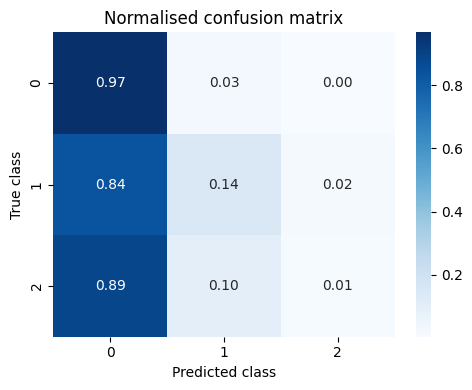

In [57]:
# ===============================
# Confusion-matrix heat-map (normalised row-wise)
# ===============================
print("----- Confusion Matrix (normalised) -----")
cm  = confusion_matrix(y_true_label, y_pred_label, labels=[0,1,2])
cmn = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues", xticklabels=["0","1","2"], yticklabels=["0","1","2"])
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Normalised confusion matrix")
plt.tight_layout()
plt.show()